In [1]:
import pandas as pd
import scipy.io
import numpy as np

In [2]:
data = scipy.io.loadmat(r"ex_2.mat")
acel = data["aceleracao"][0] 
ppg = data["fotopletismograma"][0]

##### Questão 2:

##### a) Método de filtragem para atenuar os artefatos presentes no fotopletismograma:
##### O método proposto para resolver o problema consiste em utilizar o algoritmo LMS, identificado pelo filtro: $h(n)$ e efetuar a otimização do erro a partir da norma $L2$. Dessa forma, pode-se treinar o algoritmo para encontrar o erro $e(n)$ a partir do sinal do acelerômetro $a(n)$ e o sinal do fotopletismograma $x(n)$, que resulta no sinal $y(n)$:

$$
y(n) = x(n) + e(n)
$$
$$
e(n) = \sum_{N-1}^{i=0}h_{i}a(n-i)
$$

##### Substituindo-se $e(n)$ na primeira equação, temos que saída do primeiro sistema $y(n)$ é a convolução da resposta do filtro com o sinal do acelerôemtro:

$$
y(n)=\sum_{i=0}^{N-1}h_{i}a(n-i) = h(n)\ast 
$$

##### A partir do sinal $y(n)$, foi possível aplicar o sistema LMS com a atualização dos pesos pela norma $L2$, obtendo-se:

$$
y(n) - w(n)\ast a(n)=\sum_{i=0}^{N-1}h_{i}a(n-i) - \sum_{i=0}^{N-1}w_{j}a(n-j)
$$

##### Onde $w(n)$ é atualizado por:

$$
w^{\ast}(n) = min\left\| \widehat{x}  \right\|_{2}
$$

##### Diagrama demonstrando o funcionamento do algoritmo.

![alt text](diagram_1.png)

##### Dessa forma, foi obtido o sinal do PPG filtrado:

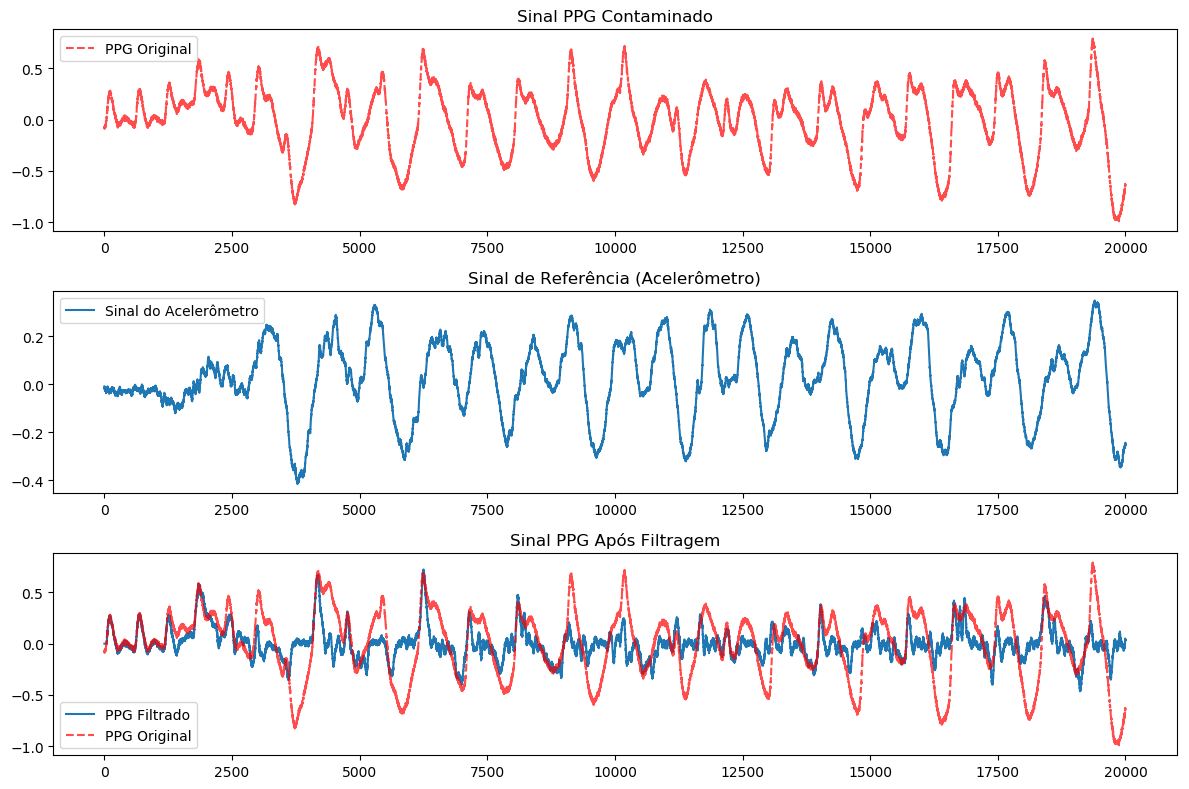

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

def lms_artifact_removal(ppg, accel, mu, n_taps):
    T = len(ppg)
    w = np.zeros(n_taps)  # Filter coefficients
    ppg_clean = np.zeros(T)  # Cleaned PPG signal
    artifact_est = np.zeros(T)  # Estimated artifact
    l2_errors = []  # Store L2 errors

    for n in range(n_taps, T):
        x = accel[n - n_taps:n][::-1]  # Input window (reversed for FIR filtering)
        artifact = np.dot(w, x)  # Artifact estimate
        e = ppg[n] - artifact  # Error signal
        w += 2 * mu * e * x  # Update weights
        artifact_est[n] = artifact
        ppg_clean[n] = e  # Remove the artifact from the PPG signal

        # Calculate L2 error up to the current point
        l2_error = np.sqrt(np.sum((ppg[:n+1] - ppg_clean[:n+1]) ** 2))
        l2_errors.append(l2_error)

    return ppg_clean, artifact_est, l2_errors


T = 20000

# Parâmetros do filtro
mu = 0.01        # Taxa de aprendizado
n_taps = 50      # Número de coeficientes

# Aplicar o filtro LMS
ppg_filtrado, artifact_acel, l_2_erros = lms_artifact_removal(ppg, acel, mu, n_taps)

# Plotar os resultados
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(ppg, label="PPG Original", linestyle="--", alpha=0.7, color="red")
plt.title("Sinal PPG Contaminado")
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(acel, label="Sinal do Acelerômetro")
plt.title("Sinal de Referência (Acelerômetro)")
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(ppg_filtrado, label="PPG Filtrado")
plt.plot(ppg, label="PPG Original", linestyle="--", alpha=0.7, color="red")
plt.title("Sinal PPG Após Filtragem")
plt.legend()

plt.tight_layout()
plt.show()


##### b) Filtro de Wiener:

In [21]:
def manual_autocorrelation(x, lag):
    n = len(x)
    mean_x = np.mean(x)
    if lag == 0:
        cov = np.sum((x) * (x)) / (n - lag)
    else:
        cov = np.sum((x[:-lag]) * (x[lag:])) / (n - lag)
    return cov 

def autocorrelation_matrix(x, max_lag):
    autocorr_matrix = np.zeros((max_lag + 1, max_lag + 1))
    for i in range(max_lag + 1):
        for j in range(max_lag + 1):
            lag = abs(i - j)
            autocorr_matrix[i, j] = manual_autocorrelation(x, lag)
    return autocorr_matrix

def compute_cross_correlation(x, d, M):
    N = len(d)
    p = np.zeros(M)
    for k in range(M):
        p[k] = np.sum(d[k:N] * x[0:N-k]) / (N)
    return p

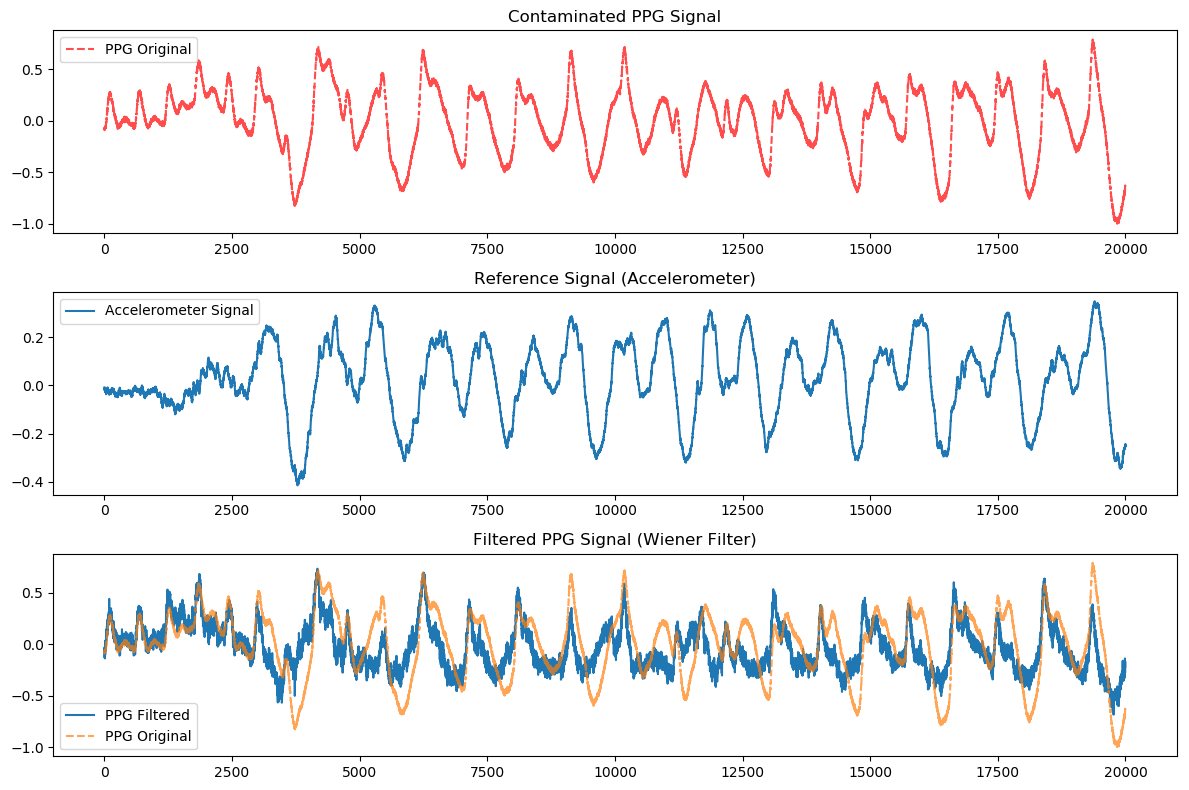

In [27]:
import numpy as np
import matplotlib.pyplot as plt

def wiener_filter(ppg, accel, n_taps):
    """
    Wiener filter for artifact removal.
    
    Parameters:
        ppg (np.array): Contaminated PPG signal
        accel (np.array): Acceleration signal (reference)
        n_taps (int): Number of filter coefficients (filter order)
    
    Returns:
        e (np.array): Filtered PPG signal
        y (np.array): Estimated artifact
        w (np.array): Wiener filter coefficients
    """
    N = len(ppg)
    
    # Construct reference matrix X using n_taps
    X = np.zeros((N - n_taps + 1, n_taps))
    for i in range(n_taps):
        X[:, i] = accel[i:N - n_taps + 1 + i]
    
    # Truncate the PPG signal to match dimensions
    d = ppg[n_taps - 1:]
    
    # Wiener filter computation
    R = autocorrelation_matrix(accel, (n_taps-1))
    p = compute_cross_correlation(accel, d, n_taps)
    w = np.dot(np.linalg.inv(R), p.T)
    y = X @ w                 # Estimated artifact
    e = d - y                 # Filtered PPG signal (error)
    
    return e, y, w


# Example data
T = 20000

# Wiener filter parameters
n_taps = 5  # Filter order

# Apply Wiener filter
ppg_fil, artefato_estimado, w = wiener_filter(ppg, acel, n_taps)

# Plot results
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(ppg, label="PPG Original", linestyle="--", alpha=0.7, color="red")
plt.title("Contaminated PPG Signal")
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(acel, label="Accelerometer Signal")
plt.title("Reference Signal (Accelerometer)")
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(ppg_fil, label="PPG Filtered")
plt.plot(ppg, label="PPG Original", linestyle="--", alpha=0.7)
plt.title("Filtered PPG Signal (Wiener Filter)")
plt.legend()

plt.tight_layout()
plt.show()



##### c) Filtragem Utilizando o algoritmo LMS:

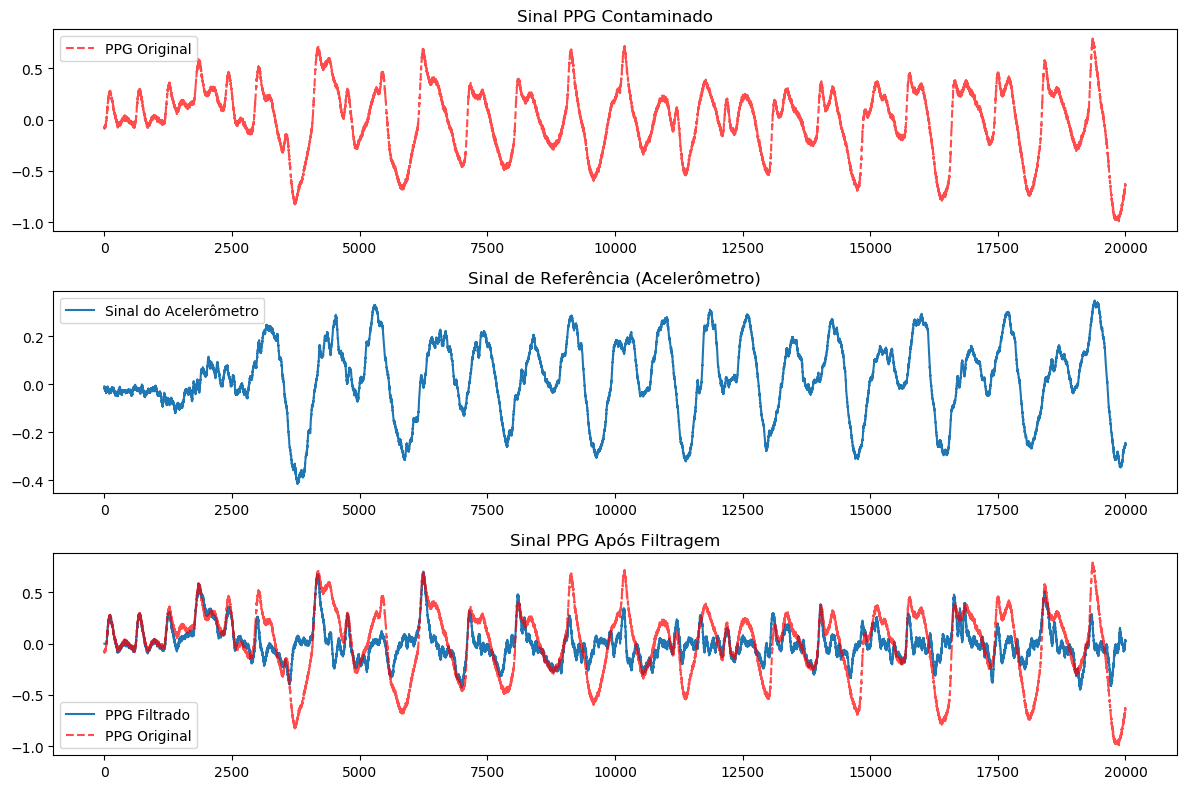

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def lms_filter(ppg, accel, mu, n_taps):
    N = len(ppg)
    w = np.zeros((n_taps, N))  # Coeficientes do filtro ao longo do tempo
    y = np.zeros(N)            # Sinal estimado (artefato)
    e = np.zeros(N)            # Erro (sinal filtrado)
    
    x = np.zeros((N, n_taps))
    for i in range(n_taps, N):
        x[i] = accel[i-n_taps:i][::-1] 

    for n in range(n_taps, N):
        y[n] = np.dot(w[:, n - 1], x[n])  # Estima o artefato
        e[n] = ppg[n] - y[n]             # Erro (sinal sem artefato)
        w[:, n] = w[:, n - 1] + mu * e[n] * x[n]  # Atualiza os pesos

    return e, y, w

T = 20000

# Parâmetros do filtro
mu = 0.01        # Taxa de aprendizado
n_taps = 50       # Número de coeficientes

# Aplicar o filtro LMS
ppg_filtrado, artefato_estimado, pesos = lms_filter(ppg, acel, mu, n_taps)

# Plotar os resultados
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(ppg, label="PPG Original", linestyle="--", alpha=0.7, color="red")
plt.title("Sinal PPG Contaminado")
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(acel, label="Sinal do Acelerômetro")
plt.title("Sinal de Referência (Acelerômetro)")
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(ppg_filtrado, label="PPG Filtrado")
plt.plot(ppg, label="PPG Original", linestyle="--", alpha=0.7, color="red")
plt.title("Sinal PPG Após Filtragem")
plt.legend()

plt.tight_layout()
plt.show()


##### d) Comparando-se os dois métodos empregados, pode-se destacar a maior adaptabilidade do filtro $LMS$ em relação ao filtro de Wiener, devido ao filtro de Wiener considerar um sinal estacionário, o que ocasinou um maior ruído na filtragem. Pode-se verificar também uma menor velocidade de covergência e uma maior robustez do algoritmo $LMS$ em relação ao filtro de Wiener, devido à utilização de um tamanho do passo: $\mu = 0.01$. Houve também um menor custo computacional, visto que o filtro de Wiener exige os cálculos da Matriz inversa e também uma menor requisição de memória tendo em vista que o filtro de Wiener requer o armazenamento de todo o sinal. 